# Chaines de Markov et épidémiologie : propagation d’une épidémie dans une population

## Ben KABONGO BUZANGU

### L3 Info Sorbonne Université

Novembre 2021

L’objectif de ce projet est de manipuler des chaînes de Markov pour étudier la propagation d’une épidémie dans une population.

Nous allons étudier des populations constituées de 3 types d’individus. Chaque individu est dans un
des 3 états suivant : `sain S`, `infecté I` ou `guéri R`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

## 1. Apprentissage des paramètres du modèle à partir des données

Dans notre premier modèle, on note qu'un individu ne peut passer que de `S` à `I` ou de `I` à `R`.
`I` dépend de `S`, `R` dépend de `I`, et évidemment `R` dépend que de `R`.

### Estimation des probabilités de transition
On définit une première séquence observée sur un individu au cours de 10 jours, par la variable `seq`

In [2]:
S = 'S'
I = 'I'
R = 'R'
states = np.array([S, I, R])
seq = np.array([S, S, S, I, I ,I ,I , I, I, R])
print(seq)

['S' 'S' 'S' 'I' 'I' 'I' 'I' 'I' 'I' 'R']


Déterminons la liste des transitions possibles.

In [3]:
seq_transitions = []
for i in range(1, len(seq)):
    seq_transitions.append([seq[i-1], seq[i]])
    if i == len(seq)-1:
        seq_transitions.append([seq[i], seq[i]])
seq_transitions = np.array(seq_transitions)
print(seq_transitions)

[['S' 'S']
 ['S' 'S']
 ['S' 'I']
 ['I' 'I']
 ['I' 'I']
 ['I' 'I']
 ['I' 'I']
 ['I' 'I']
 ['I' 'R']
 ['R' 'R']]


Ecrivons la fonction `get_matrix_transitions` qui prend en paramètre une séquence de transitions donnée et la liste des états et retourne la matrice de transition associée.

In [4]:
def get_matrix_transitions(seq_transitions, states):
    n = len(states)
    matrix_transitions = np.zeros((n, n))
    for j in range(n):
        state_transitions = seq_transitions[np.where(seq_transitions[:,0]==states[j])[0]]
        for i in range(n):
            _next = state_transitions[np.where(state_transitions[:,1]==states[i])[0]]
            matrix_transitions[j, i] = len(_next)/len(state_transitions)
    return matrix_transitions

En fonction des états précédents, calculons la probabilité des états suivants. Et déterminons la matrice de transitions.

In [5]:
print(get_matrix_transitions(seq_transitions, states))

[[0.66666667 0.33333333 0.        ]
 [0.         0.83333333 0.16666667]
 [0.         0.         1.        ]]


### Jeu de données

Lisons les données d'observations de 100 individus pendant 200 jours.

In [6]:
data = np.loadtxt('data_exo1.txt')
print(data.shape)
print(data)

(100, 201)
[[0. 0. 0. ... 2. 2. 2.]
 [0. 0. 0. ... 2. 2. 2.]
 [0. 0. 0. ... 2. 2. 2.]
 ...
 [0. 1. 1. ... 2. 2. 2.]
 [0. 0. 1. ... 2. 2. 2.]
 [0. 0. 0. ... 2. 2. 2.]]


Comptablisons toutes les différentes transitions d'états sur tous les individus.

In [7]:
m, n = data.shape
seq_transitions = []
for j in range(m):
    seq = data[j]
    for i in range(1, n):
        seq_transitions.append([seq[i-1], seq[i]])
        if i == n-1:
            seq_transitions.append([seq[i], seq[i]])        
seq_transitions = np.array(seq_transitions)
print(seq_transitions)

[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [2. 2.]
 [2. 2.]
 [2. 2.]]


Calcuons la matrice de transition des états en fonction des données lues.

In [8]:
print(get_matrix_transitions(seq_transitions, range(3)))

[[0.92435703 0.07564297 0.        ]
 [0.         0.93527508 0.06472492]
 [0.         0.         1.        ]]


## 2. Description du premier modèle

<img src="model1.png">

### Matrice de transition
Soit A la matrice de transitions des états.

In [9]:
A = np.array([[.92, .08, .0], [.0, .93, .07], [.0, .0, 1.]])
print(A)

[[0.92 0.08 0.  ]
 [0.   0.93 0.07]
 [0.   0.   1.  ]]


Ecrivons une fonction qui vérifie qu'une matrice est stochastique.

Chaque ligne d'une matrice stochastique doit sommer à 1 ; c'est une condition nécessaire pour qu'une matrice soit stochastique.

Cependant sur certaines instances de tableaux numpy, la fonction `np.sum` renvoie des valeurs très proches de 1 (au lieu d'exactement 1), s'agissant de valeurs flottantes. Afin de palier à ce problème, nous ajoutons un biais de $10^{-6}$ pour correctement effectuer les comparaisons.

In [10]:
def is_stochastic(matrix):
    return np.all(matrix >= 0) and np.all(matrix.sum(axis=1) >= 1 - 1e-6)

La matrice A est stochastique. Vérifions-le.

In [11]:
print(A, "est-elle stochastique ?", ("oui" if is_stochastic(A) else "non"))

[[0.92 0.08 0.  ]
 [0.   0.93 0.07]
 [0.   0.   1.  ]] est-elle stochastique ? oui


### Distribution de $\pi_{t}$

Soit `phi0` la distribution de probabilité initiale.

In [12]:
phi0 = np.array([.9, .1, .0])
print(phi0)

[0.9 0.1 0. ]


Calculons `phi1` en fonction de `phi0` et de `A`.

In [13]:
phi1 = np.dot(phi0, A)
print(phi1)

[0.828 0.165 0.007]


Fixons le nombre des observations des individus à 150 jours. Nous créons alors un vecteur `T` qui contient la numérotation de ces jours.

In [14]:
T = np.arange(150)

Calculons la distribution de probabilité des états, pour `T` de 1 à 150. Nous mettons dans la matrice `phits` le résultat obtenu.

In [15]:
phits = np.zeros((150, 3))
phits[0, np.argmax(phi0)] = 1.
phits[1] = phi0
for i in range(2, 150):
    phits[i] = np.dot(phits[i-1], A)

Représentons graphiquement les variations des états `S`, `I` et `R` en fonction du temps `T`.

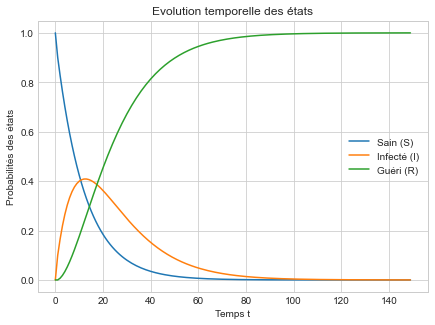

In [16]:
fig = plt.figure(figsize=(7, 5))
plt.title("Evolution temporelle des états")
plt.plot(T, phits[:,0], label='Sain (S)')
plt.plot(T, phits[:,1], label="Infecté (I)")
plt.plot(T, phits[:,2], label="Guéri (R)")
plt.xlabel("Temps t")
plt.ylabel("Probabilités des états")
plt.legend()
plt.show()

Nous observons qu'au tout début de la pandémie, tous les individus sont sains.
Le nombre d'individus sains (non encore infectés) décroit très rapidement et devient quasiment nul aux instants t avoisants et plus grands que 60.

Le nombre d'individus infectés commence très bas, pour ensuite croître assez rapidement, mais dépasse pas le seuil des 40% de la population. Après avoir atteint son seuil, le nombre d'individus infectés décroit, moins vite que le nombre d'individus sains. Aux instants t avoisinants et plus grands que 80, le nombre d'individus infectés devient quasiment nul.

On observe des guérisons les instants après la première infection. Le nombre d'individus guéris est au début nul ; ensuite, il croît. Il ne connait pas de décroissance ; tout comme le nombre d'individus sains ne connait pas de croissance ; seul le nombre d'individus infectés connait une croissance et une décroissance aux alentours d'un certain seuil, qui représente le pic de l'épidémie.
Aux instants t avoisinants et plus grands que 80, une fois que tous les individus ont été infectés, tous les individus sont guéris. L'épidémie se termine alors ; car après la guérison, plus aucun individu ne peut encore être infecté.

### Analyse théorique

Ecrivons la fonction `theorical_analysis` qui effectue l'analyse théorique d'un modèle.

Cette fonction prend en paramètres la matrice de transition `A` associée au modèle, la distribution de probabilités initiale `phi0` et le temps d'observation `t`.

Elle effectue les mêmes analyses théoriques faites ci-dessus : calculer les distributions de probabilités pour les temps variant de 0 à `t` et afficher graphiquement la distribution théorique en fonction du temps.

In [17]:
def theorical_analysis(A, phi0, t):
    T = np.arange(t)

    phits = np.zeros((t, 3))
    phits[0][np.argmax(phi0)] = 1.
    phits[1] = phi0
    for i in range(2, t):
        phits[i] = np.dot(phits[i-1], A)
        
    fig = plt.figure(figsize=(7, 5))
    plt.title("Evolution temporelle des états")
    plt.plot(T, phits[:,0], label='Sain (S)')
    plt.plot(T, phits[:,1], label="Infecté (I)")
    plt.plot(T, phits[:,2], label="Guéri (R)")
    plt.xlabel("Temps t")
    plt.ylabel("Probabilités des états")
    plt.legend()
    plt.show()

### Tirage aléatoire des états

Ecrivons la fonction `generate_sequences` qui génère `n` (le nombre d'individus) séquences aléatoires d'une taille `t` (le nombre de jours), en fonction de la distribution de probabilités initiale `phi0` et de la matrice de transition `A`. 

In [18]:
def generate_sequences(A, phi0, t, n):
    sequences = np.zeros((n, t))
    for j in range(n):
        sequences[j, 0] = np.argmax(phi0)
        for i in range(1, t):
            sequences[j, i] = np.random.choice([0., 1., 2.], p=A[int(sequences[j, i-1])])
    return sequences

Générons une séquence d'états aléatoires pour un individu observé pendant 150 jours.

In [19]:
print(generate_sequences(A, phi0, 150, 1))

[[0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2.]]


On remarque bien que la distribution des probabilités et les transitions possibles sont respectées.

### Modélisation d'une population

Générons des séquences aléatoires pour 200 individus, que nous stockons dans la matrice `sequences`.

In [20]:
sequences = generate_sequences(A, phi0, 150, 200)
print(sequences.shape)

(200, 150)


Pour chaque jour et pour les trois états, comptons le nombre d'individus. Mettons le résultat dans la matrice `phits`.

In [21]:
phits = np.zeros((150, 3))
phits[:,0] = np.sum(sequences == 0., axis=0)
phits[:,1] = np.sum(sequences == 1., axis=0)
phits[:,2] = np.sum(sequences == 2., axis=0)
phits /= 200

Représentons l'évolution de cette population en fonction du temps.

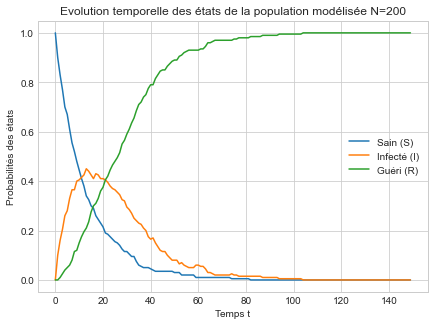

In [22]:
fig = plt.figure(figsize=(7, 5))
plt.title("Evolution temporelle des états de la population modélisée N=200")
plt.plot(T, phits[:,0], label='Sain (S)')
plt.plot(T, phits[:,1], label="Infecté (I)")
plt.plot(T, phits[:,2], label="Guéri (R)")
plt.xlabel("Temps t")
plt.ylabel("Probabilités des états")
plt.legend()
plt.show()

Les résultats observés sur la population générée sont en accord avec les résultats théoriques.

### Analyse des observations

Ecrivons la fonction `observed_analysis` qui effectue l'analyse d'une population générée aléatoirement en fonction d'un modèle.

Cette fonction prend en paramètres la matrice de transition `A` associée au modèle, la distribution de probabilités initiale `phi0`, le temps d'observation `t` et la taille de la population `n`.

Elle effectue les mêmes analyses d'observation faites ci-dessus : générer les séquences d'observation de la population, calculer les distributions de probabilités pour les temps variant de 0 à `t` et afficher graphiquement la distribution théorique en fonction du temps.

In [23]:
def observed_analysis(A, phi0, t, n):
    T = np.arange(t)
    
    sequences = generate_sequences(A, phi0, t, n)

    phits = np.zeros((t, 3))
    phits[:,0] = np.sum(sequences == 0., axis=0)
    phits[:,1] = np.sum(sequences == 1., axis=0)
    phits[:,2] = np.sum(sequences == 2., axis=0)
    phits /= n
        
    fig = plt.figure(figsize=(7, 5))
    plt.title(f"Evolution temporelle des états de la population modélisée N={n}")
    plt.plot(T, phits[:,0], label='Sain (S)')
    plt.plot(T, phits[:,1], label="Infecté (I)")
    plt.plot(T, phits[:,2], label="Guéri (R)")
    plt.xlabel("Temps t")
    plt.ylabel("Probabilités des états")
    plt.legend()
    plt.show()

### Analyses d'autres populations

Faisons les mêmes analyses sur une population de 5 individus.

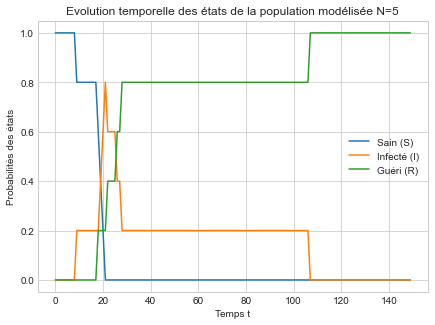

In [24]:
observed_analysis(A, phi0, 150, 5)

Les résultats obtenus sont quasiment similaires à ceux obtenus précédemment.

Pour une petite population, constituée que de cinq individus dans ce cas, le nombre d'individus sains devient très vite nul. A l'instant `t = 20`, plus aucun individu n'est sain.

Le nombre d'individus infectés croit progressivement, étape par étape, atteint le seuil des `60%` de la population aux instants proches de `t = 20`, et décroit jusqu'à s'annuler aux voisinnages de `t = 50`.

Le nombre d'individus guéris croit également progressivement. Aux voisinnages de `t = 30`, le nombre d'individus guéris est plus grand que le nombre d'individus sains et d'individus infectés. Aux voisinnages de l'instant `t = 30`, tous les individus sont guéris.

Faisons les mêmes analyses sur une population de 5000 individus.

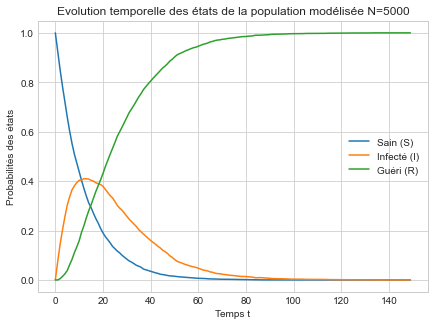

In [25]:
observed_analysis(A, phi0, 150, 5000)

Les résultats sont ici encore plus proche des résultats théoriques obtenus.
Plus la population est grande, plus on  se rapproche des résultats théoriques.

Au départ, tous les individus sont sains. S'ensuit l'infection de quelques individus de la population, qui, entraîne la baissse du nombre d'individus sains et la hausse d'individus infectés. La gurésion des individus infectés intervient rapidement après leur infection.

L'infection ne dépasse pas un certain seuil. Le nombre d'individus sains s'annule : tous les dindividus ont été infectés. Le nombre d'individus guéris est maximum : tous les individus infectés finissent par guérir.

### Pic de l'épidémie

Soit les observations faites initialement, sur une population de 200 individus, au cours de 150 jours. Déterminons le nombre d'individus infectés maximal en fonction du temps et déterminons le jour où le pic est atteint.

In [26]:
sequences = generate_sequences(A, phi0, 150, 200)
number_i = np.sum(sequences == 1., axis=0)
print(f"Le pic de l'épidémie est atteint le {np.argmax(number_i) + 1}ieme jour.")
print(f"Le nombre d'individus infectés ce jour-là est de {np.max(number_i)} individus.")

Le pic de l'épidémie est atteint le 16ieme jour.
Le nombre d'individus infectés ce jour-là est de 87 individus.


### Longueur de l’infection

#### Longueur moyenne d'infection

Soit la simulation précédente `sequences` des 200 individus, au cours de 150 jours durant lesquels ils ont été observés.

Calculons les longueurs de séquences de `I` pour chaque individu, que nous stockons dans `length_i`.

In [27]:
length_i = np.count_nonzero(sequences == 1., axis=1)
print(length_i.shape)
print(length_i)

(200,)
[ 6  3  6 11 37  8  8  1 25 44 30  3  3  5 11 30  7 17 29  7 28 16 24 17
  9  7 10  9  1  1 30  6 20 14  2  5 12  2  2  1 16 16 11  1 11 15 38 29
  2  3 27 12  3 12  2  9 30 24  5  3  1 21  6  2 52 16  9 11 16  9 26 54
  6  5  2 28  1 65  4  4  9  1 23 37 23  5 39 28 12 12 14 10 13 16  2 16
 15  8  6 14 13 15  2  8 18 12 69  8 13 10  7 19  1  1 32 11 28 32  9 11
  7  5  7 20 12 29  1 12 10 18 12  4 22  7 18  3  6  3 35 39 89 14 19  8
  8  5 22 16 17 13  2 27 22 15  2 12 19  1 41  1 69 24  6  1  2 18 10  1
 21 24  2 14 19  5  4 17 14 24 22 13  5 32  1  4 16 50  8  4 23  2 24  3
 10  1  8 28 46  8  1  1]


Calculons la longueur moyenne d'infection.

In [28]:
print("La longueur moyenne d'infection est de", np.mean(length_i), "jours")

La longueur moyenne d'infection est de 14.72 jours


Représentons la distribution observée de la longueur d'infection.

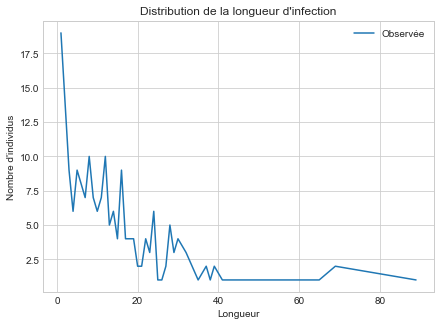

In [29]:
fig = plt.figure(figsize=(7, 5))
uo, co = np.unique(length_i, return_counts=True)
plt.title("Distribution de la longueur d'infection")
plt.plot(uo, co, label="Observée")
#plt.bar(uo, co, label="Observée")
plt.xlabel("Longueur")
plt.ylabel("Nombre d'individus")
plt.legend()
plt.show()

#### Longueur d'infection théorique

Les longueurs d'infections calculées précédemment sont celles que nous avons observées.

Soit `p`, la probabilité de passer de l'état `I` à l'état `R`.
Les longueurs théoriques suivent des lois géométriques $G(p)$ de paramètre $p$.

Calculons `p` et calculons la longueur théorique.

In [30]:
p = A[1, 2]
q = 1 - p
print("La probabilité de passer de l'état I à l'état R est de", p)
print("La longueur d'infection théorique est de", 1/p, "jours")

La probabilité de passer de l'état I à l'état R est de 0.07
La longueur d'infection théorique est de 14.285714285714285 jours


Calculons la distribution théorique de la longueur d'infection. Stockons-la dans le tableau `length_it`.

In [31]:
length_it = np.zeros_like(length_i, dtype=float)
for i in range(0, len(length_i)):
    length_it[i] = (q**i)*p*200

Représentons la distribution théorique de la longueur d'infection.

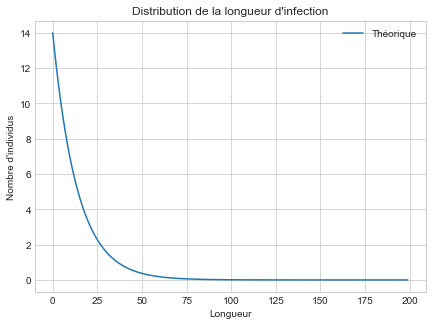

In [32]:
fig = plt.figure(figsize=(7, 5))
plt.title("Distribution de la longueur d'infection")
plt.plot(length_it, label="Théorique")
plt.xlabel("Longueur")
plt.ylabel("Nombre d'individus")
plt.legend()
plt.show()

#### Distributions de la longueur d'infection

Représentons les distributions théoriques et observées de la longueur d'infection.

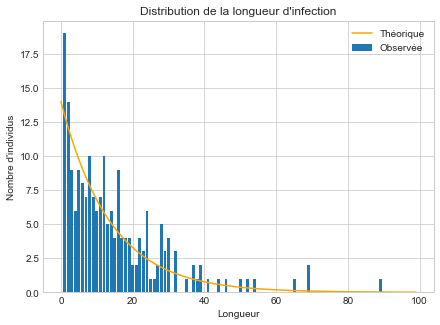

In [33]:
fig = plt.figure(figsize=(7, 5))
plt.title("Distribution de la longueur d'infection")
plt.bar(uo, co, label="Observée")
plt.plot(np.arange(100), length_it[:100], label="Théorique", color="orange")
plt.xlabel("Longueur")
plt.ylabel("Nombre d'individus")
plt.legend()
plt.show()

## 3. Modèle ergodique

### Analyse du modèle

Considérons à présent que les individus guréis ont une probabilité de `0.02` de perdre leur immunité. La probabilité de rester sur l'état `R` devient `0.98` et celle de passer de `R` à `S` devient donc `0.02`.

<img src="model2.png">

#### Matrice de transition

Ecrivons la nouvelle matrice `A` de transition correspondante.

In [34]:
A = A.copy()
A[2,0] = 0.02
A[2,2] = 0.98
print(A)

[[0.92 0.08 0.  ]
 [0.   0.93 0.07]
 [0.02 0.   0.98]]


Vérifions que `A` est bien une matrice stochastique.

In [35]:
print(A, "est-elle stochastique ?", ("oui" if is_stochastic(A) else "non"))

[[0.92 0.08 0.  ]
 [0.   0.93 0.07]
 [0.02 0.   0.98]] est-elle stochastique ? oui


#### Analyses théoriques

Effectuons l'analyse théorique de notre nouveau modèle, sur 150 jours d'observations.

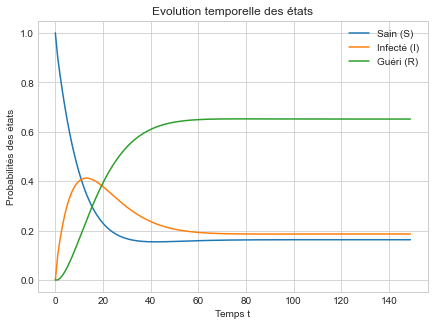

In [36]:
phi0 = [0.9, 0.1, 0]
theorical_analysis(A, phi0, 150)

Avant l'épidémie, tous les individus sont sains. La probabilité d'être sain est maximale, égale à 1.
au cours de l'épidémie, la probabilité d'être sain baisse très vite. Cependant, elle ne devient pas nulle. En d'autres termes, un individu peut d'une certaine façon connaitre tous les états et revenir à l'état sain.
Aux instants proches de `t = 60`, la probabilité pour un individu d'être sain semble ne plus changer. Elle prend une valeur finale inférieure et proche de `0.2`.

La probabilité pour un individu d'être infecté, au début de la pandémie est de 0. Elle croît en même temps que baisse la probabilité d'être sain. Aux instants proches de `t = 15`, elle atteint son seuil : sa probabilité maximale, qui, approxime `0.4`. Ensuite, elle baisse légèrement jusqu'à `0.2`. Au même instant que la probabilité d'être sain se fixe, la probabilité d'être infecté se fixe aussi. Elle prend une valeur finale inférieure et proche de `0.2`, et supérieure à la probabilité d'être sain.

La proportion d'individus guéris est au départ de 0. Elle croit alors que baissent les probabilités d'être sain et d'être infecté. Elle ne change quasiment plus en même temps que les deux autres probabilités, aux instants proches de `t = 60` et prend une valeur finale approximant de `0.62`.

Aux instants `t > 60`, le vecteur des probabilités $\pi_t$ converge et les probabilités des états ne changent quasiment plus. Comme dans ce vecteur, aucune probabilité d'un état donné n'est nulle, chaque individu peut donc se trouver et transiter dans tous les autres états possibles, en fonction des probabilités de transition.

#### Analyses de populations

Générons une population de 200 individus alétoires dont les états ont été observés pendant 150 jours en fonction des nouvelles probabilités de transition.

Et comptons à nouveau pour chaque état, le nombre d'individu par jour.
Et représentons cela graphiquement.

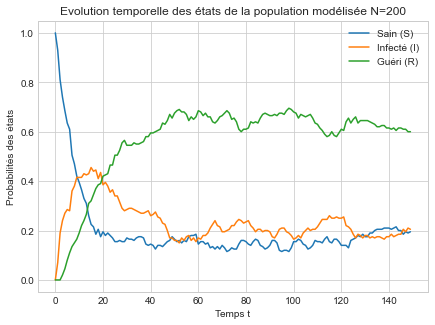

In [37]:
observed_analysis(A, phi0, 150, 200)

Faisons les mêmes analyses avec une population de 500 individus.

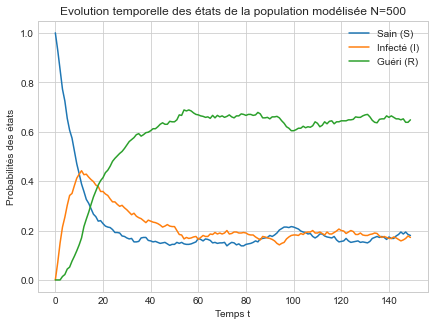

In [38]:
observed_analysis(A, phi0, 150, 500)

Faisons les mêmes analyses sur une population de 5000 individus.

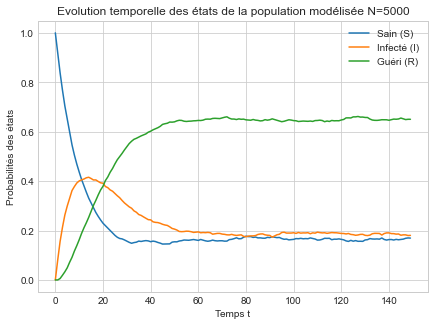

In [39]:
observed_analysis(A, phi0, 150, 5000)

Les résultats observés sur les simulations sont cohérents avec les résultats théoriques obtenus.

#### Analyses de différentes distributions de probabilités initiales

Prenons une distribution intiale `phi0` différente, et faisons les mêmes observations que ci-haut.

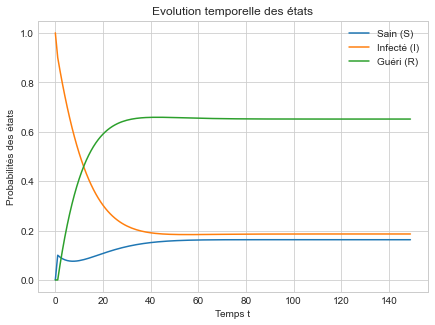

In [40]:
phi0 = [0.1, 0.9, 0]
theorical_analysis(A, phi0, 150)

Etudions l'évolution de la nouvelle distribution initiale sur une population de 5000 individus.

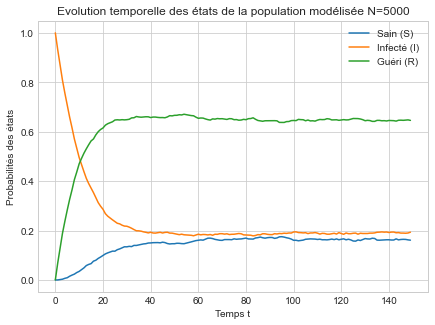

In [41]:
observed_analysis(A, phi0, 150, 5000)

Prenons d'autres distributions de probabilités initiales et effectuons les mêmes analyses théoriques.

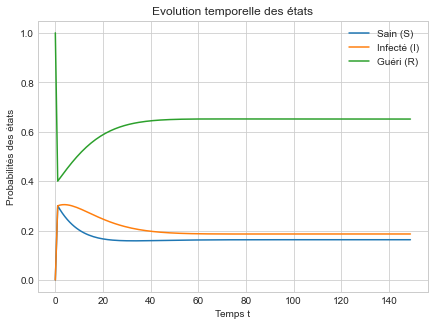

In [42]:
phi0 = [0.3, 0.3, 0.4]
theorical_analysis(A, phi0, 150)

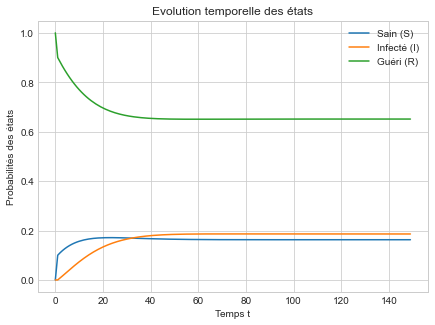

In [43]:
phi0 = [0.1, 0, 0.9]
theorical_analysis(A, phi0, 150)

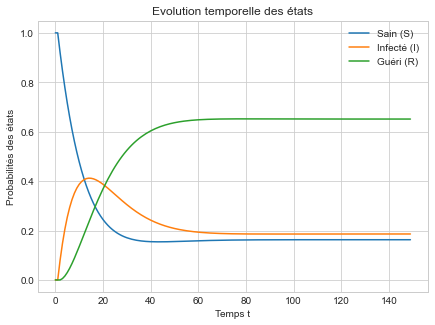

In [44]:
phi0 = [1., 0., 0.]
theorical_analysis(A, phi0, 150)

Nous constatons que, peu importe la distribution de probabilités initiale, à un instant donné, les probabilités des états deviennent stationnaires et égales à des valeurs données pour toutes les distributions. Nous déterminerons les valeurs de ces probabilités dans la suite.

En d'autres termes, toutes les distributions de probabilités initiales conduisent à la même fin de distribution de probabilités.

#### Classification des états et nature de la chaîne de Markov

Les états de la chaîne de Markov:

`Tous les états communiquent` les uns aux autres, car, à première vue les états on accès les uns aux autres de façon chaînée (S -> I; I -> R; R -> S) et la relation de communication entre les états est une relation d'équivalence.
Le graphe des états ne possède une seule composante fortement connexe.

Tous les états sont de période 1. Ils sont tous `apériodiques`.

La chaîne de Markov de ce modèle est:
- `Apériodique`: car tous les états sont de période 1. Le graphe des états présente des cycles.
- `Irréductible`: car tout état est accessible à partir de n'importe quel autre état.
Notamment, il n'existe pas de composantes absorbantes dans le graphe des états du modèle. Tous les états communiquent ; il existe donc une unique classe d'équivalence ; la chaîne est donc irréductible.

#### Puissances de la matrice de transition
Calculons la matrice $A^2$.

In [45]:
A_ = np.linalg.matrix_power(A, 2)
print("Soit A^2\n", A_)
print("Elle", ("est" if is_stochastic(A_) else "n'est pas"), "stochastique")

Soit A^2
 [[0.8464 0.148  0.0056]
 [0.0014 0.8649 0.1337]
 [0.038  0.0016 0.9604]]
Elle est stochastique


La matrice $A^2$ correspond à la nouvelle distribution des probabilités à l'instant `t = 2`.

Calculons d'autres puissances de la matrice de transition $A$.
Elles correspondent chacune, pour une puissance `n` donnée, à la distribution de probabilités à l'instant `t = n`.

In [46]:
A_ = np.linalg.matrix_power(A, 3)
print("Soit A^3\n", A_)
print("Elle", ("est" if is_stochastic(A_) else "n'est pas"), "stochastique")

Soit A^3
 [[0.7788   0.205352 0.015848]
 [0.003962 0.804469 0.191569]
 [0.054168 0.004528 0.941304]]
Elle est stochastique


In [47]:
A_ = np.linalg.matrix_power(A, 4)
print("Soit A^4\n", A_)
print("Elle", ("est" if is_stochastic(A_) else "n'est pas"), "stochastique")

Soit A^4
 [[0.71681296 0.25328136 0.02990568]
 [0.00747642 0.74847313 0.24405045]
 [0.06866064 0.00854448 0.92279488]]
Elle est stochastique


In [48]:
A_ = np.linalg.matrix_power(A, 10)
print("Soit A^10\n", A_)
print("Elle", ("est" if is_stochastic(A_) else "n'est pas"), "stochastique")

Soit A^10
 [[0.44297079 0.39801803 0.15901117]
 [0.03975279 0.49272305 0.46752416]
 [0.12789936 0.04543176 0.82666888]]
Elle est stochastique


In [49]:
A_ = np.linalg.matrix_power(A, 70)
print("Soit A^70\n", A_)
print("Elle", ("est" if is_stochastic(A_) else "n'est pas"), "stochastique")

Soit A^70
 [[0.1609542  0.18752273 0.65152307]
 [0.16288077 0.18439454 0.65272469]
 [0.16322409 0.18614945 0.65062646]]
Elle est stochastique


In [50]:
A_ = np.linalg.matrix_power(A, 100)
print("Soit A^100\n", A_)
print("Elle", ("est" if is_stochastic(A_) else "n'est pas"), "stochastique")

Soit A^100
 [[0.16274151 0.18585816 0.65140033]
 [0.16285008 0.18597378 0.65117614]
 [0.16278603 0.18611438 0.65109959]]
Elle est stochastique


#### Distribution de probabilités stationnaire

Calculons, à partir des puissances de la matrice de transition `A`, la distribution de probabilités stationnaire.

In [51]:
An_1 = np.zeros_like(A)
An = A.copy()

#while not np.all(np.abs(An - An_1) < 1e-3):
while not np.all(An == An_1):
    An_1 = An.copy()
    An = np.dot(An, A)

print("La distribution de probabilités stationnaire est", An)

La distribution de probabilités stationnaire est [[0.1627907  0.18604651 0.65116279]
 [0.1627907  0.18604651 0.65116279]
 [0.1627907  0.18604651 0.65116279]]


Représentons la distribution de probabilité stationnaire.

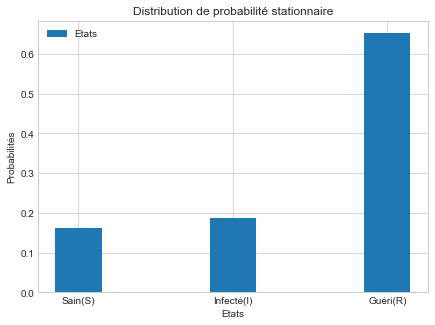

In [52]:
fig = plt.figure(figsize=(7,5))
plt.title("Distribution de probabilité stationnaire")
plt.bar(np.array(["Sain(S)", "Infecté(I)", "Guéri(R)"]), An[0], label="Etats", width=0.3)
plt.xlabel("Etats")
plt.ylabel("Probabilités")
plt.legend()
plt.show()

Faisons des analyses théoriques avec comme distribution de probabilités initiale la distribution de probabilités stationnaire.

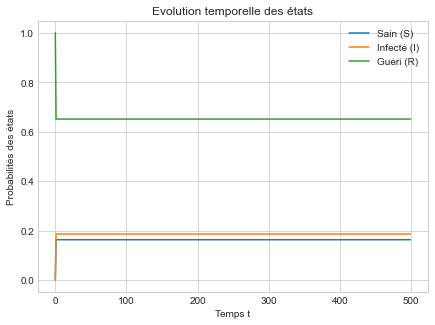

In [53]:
theorical_analysis(A, An[0], 500)

Nous avons trouvé la distribution de probabilité stationnaire. C'est une distribution de probabilité toujours atteinte à un temps `t` donné, en fonction de la distribution de probabilité initiale. On le remarque bel et bien sur toutes les simulations faites précédemment sur ce modèle.

### Longueur d'immunité

#### Longueur moyenne d'immunité

Nous nous rappelons dans le modèle précédent que dans les séquences aléatoires générées, les états se succédaient sans retour à un état déjà rencontré. Par exemple `0 0 1 1 1 2 2 2`.
Pour calculer la longueur d'infection (la longueur des séquences de `I`), il nous suffisait donc de compter le nombre d'états `I` d'une séquence donnée.

Dans le modèle que nous étudions, il est possible de revenir sur des états déjà rencontrés. Par exemple `0 0 1 1 2 2 0 0 1 1 2`. 
Nous cherchons à déterminer la longueur d'immunité (la longueur des séquences de `R`). Nous ne pouvons cependant pas procéder comme précédemment, car les séquences de `R` ne sont pas consécutives.

Afin de déterminer efficamment les longueurs d'immunité des différentes séquences, nous allons mettre sur pied un moyen efficace de dénombrer les différentes séquences successives de `R`.

On évitera donc de déterminer ces longueurs en itérant sur la séquence donnée. En effet, une manière intéressante de procéder est de récupérer les indices de chaque état `R` et de faire des différences systématiques entre ces indices pour déterminer les longueurs que l'on souhaite.

Voici une petite illustration. Nous générons un tableau de 50 entiers aléatoires entre 0 et 2, et nous chercherons à determiner les longueurs des suites de 2. Nous afficherons les longueurs des différentes suites de 2 rencontrées.

In [54]:
a = np.random.randint(0, 3, size=50)
lengths = []
current = 0
where = np.where(a == 2)[0]
n = len(where)
print("where:", where)
for i in range(1, n):
    current += 1
    if (where[i]-where[i-1] != 1):
        lengths.append(current)
        current = 0
    if i == n-1:
        current = max(1, current+1)
        lengths.append(current)
print("lengths:",lengths)

where: [ 2 13 19 23 26 32 37 38 44 46 49]
lengths: [1, 1, 1, 1, 1, 1, 2, 1, 1, 1]


Appliquons cela à notre situation.
Générons une séquence aléatoire d'une population de 200 individus observés pendant 150 jours. Pour chaque individu, nous prendrons la moyenne des longueurs.

Calculons les longueurs de séquences de `R` pour chaque individu, que nous stockons dans `length_r`.

In [55]:
phi0 = [1., 0., 0.]
sequences = generate_sequences(A, phi0, 150, 200)
length_r = np.zeros(200)
for j in range(200):
    lengths = []
    current = 0
    where = np.where(sequences[j] == 2)[0]
    n = len(where)
    for i in range(1, n):
        current += 1
        if (where[i]-where[i-1] != 1):
            lengths.append(current)
            current = 0
        if i == n-1:
            current = max(1, current+1)
            lengths.append(current)
    length_r[j] = 0 if lengths == [] else int(np.mean(lengths))

Calculons la longueur moyenne d'immunité.

In [56]:
print("La longueur moyenne d'immunité est de", np.mean(length_r), "jours")

La longueur moyenne d'immunité est de 46.24 jours


Représentons la distribution observée de la longueur d'immunité.

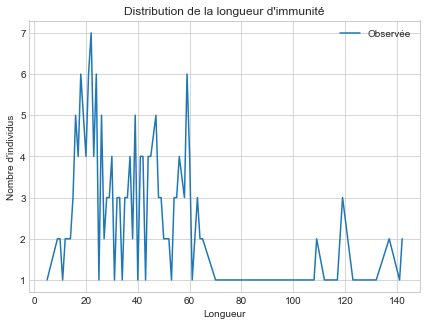

In [57]:
fig = plt.figure(figsize=(7, 5))
uo, co = np.unique(length_r, return_counts=True)
plt.title("Distribution de la longueur d'immunité")
plt.plot(uo, co, label="Observée")
#plt.bar(uo, co, label="Observée")
plt.xlabel("Longueur")
plt.ylabel("Nombre d'individus")
plt.legend()
plt.show()

#### Longueur d'immunité théorique

Les longueurs d'immunités calculées précédemment sont celles que nous avons observées.

Soit `p`, la probabilité de passer de l'état `R` à l'état `S`.
Les longueurs théoriques suivent des lois géométriques $G(p)$ de paramètre $p$.

Retrouvons `p` et calculons la longueur théorique.

In [58]:
p = A[2, 0]
q = 1 - p
print("La probabilité de passer de l'état R à l'état S est de", p)
print("La longueur d'immunité théorique est de", 1/p, "jours")

La probabilité de passer de l'état R à l'état S est de 0.02
La longueur d'immunité théorique est de 50.0 jours


Calculons la distribution théorique de la longueur d'immunité. Stockons-la dans le tableau `length_rt`.

In [59]:
length_rt = np.zeros_like(length_r, dtype=float)
for i in range(0, len(length_r)):
    length_rt[i] = (q**i)*p*200

Représentons la distribution théorique de la longueur d'immunité.

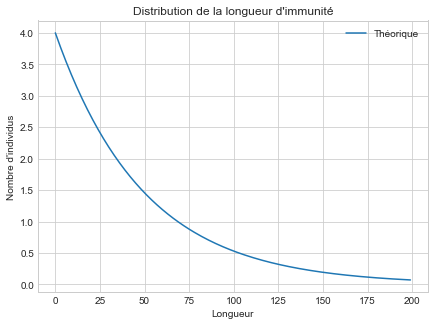

In [60]:
fig = plt.figure(figsize=(7, 5))
plt.title("Distribution de la longueur d'immunité")
plt.plot(length_rt, label="Théorique")
plt.xlabel("Longueur")
plt.ylabel("Nombre d'individus")
plt.legend()
plt.show()

#### Distributions de la longueur d'immunité

Représentons les distributions théoriques et observées de la longueur d'immunité.

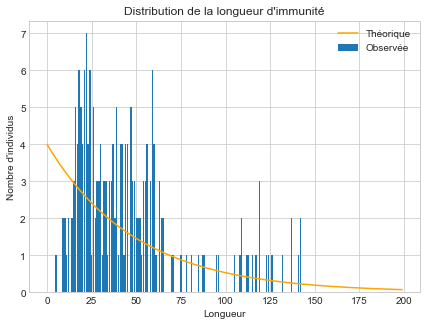

In [61]:
fig = plt.figure(figsize=(7, 5))
plt.title("Distribution de la longueur d'immunité")
plt.bar(uo, co, label="Observée")
plt.plot(length_rt, label="Théorique", color="orange")
plt.xlabel("Longueur")
plt.ylabel("Nombre d'individus")
plt.legend()
plt.show()

## 4. Confinement


### Modes et matrices de transitions

#### Modes de confinement
Les mesures de distanciations sociales peuvent être mises en place. On distngue dès à présent deux modes : le mode `confinement` et le mode `non-confinement`.

#### Matrices de transitions
En mode `non-confinement`, des infections peuvent subvenir. La matrice de transition correspondant à ce mode est notée `Anc` (matrice de non confinement), qui est une copie de la matrice de transition de l'exercice précédent.

En mode `confinement`, les individus sains ne peuvent pas devenir infectés. Ainsi, la probabilité de passer de l'état `S` à l'état `I` devient `0` ; et celle de rester à l'état `S` devient `1`. La matrice de transition correspondant à ce mode est notée `Ac` (matrice de confinement).

Initialisons les deux matrices.

In [62]:
Anc = A.copy()
print(Anc)

[[0.92 0.08 0.  ]
 [0.   0.93 0.07]
 [0.02 0.   0.98]]


In [63]:
Ac = A.copy()
Ac[0, 0] = 1.
Ac[0, 1] = 0.
print(Ac)

[[1.   0.   0.  ]
 [0.   0.93 0.07]
 [0.02 0.   0.98]]


### Simulations

Rappelons que changer de mode consiste à choisir la matrice de transition associée à ce mode.

Nous commencerons nos simulations avec un mode sans confinement. Nous passerons au mode confinement dès que le nombre d'individus atteindra les `25%`. Ensuite, dans ce mode, si le nombre d'individus infectés atteint les `10%`, nous repasserons en mode confinement.

#### Simulations théoriques

Pour nos simulations, nous allons modifier notre fonction `theorical_analysis` et écrire la fonction `confinement_theorical_analysis`. Elle prend en paramètre la matrice de transitions du mode non-confinement `Anc`, la matrice de transition du mode confinement `Ac`, la distribution de probabilité initiale `phi0`, le temps `t`, le booléen `confinement` qui indique le mode par lequel commencer les analyses, le seuil de transition des modes en fonction du pourcentage d'infection `nc_seuil` pour confiner et `c_seuil` pour déconfiner.

Cette fonction nous permettra de faire de simulations avec des paramètres différents par la suite.

En outre, elle comptera le nombre de confinements et déconfinements et affichera l'évolution des états en fonction du temps.

In [64]:
def confinement_theorical_analysis(Anc, Ac, phi0, t, confinement=False, nc_seuil=0.25, c_seuil=0.1):
    T = np.arange(t)
    
    confinements = [] # temps de confinements
    deconfinements = [] # temps de déconfinements
    
    phits = np.zeros((t, 3))
    phits[0][np.argmax(phi0)] = 1.
    phits[1] = phi0
    
    for i in range(2, t):
        A = Ac if confinement else Anc
        phits[i] = np.dot(phits[i-1], A)
        
        if confinement: # confinement
            if phits[i, 1] <= c_seuil:
                # proportion des infectés inférieur à c_seuil -> déconfinement
                confinement = False
                deconfinements.append(i)
        else:
            if phits[i, 1] >= nc_seuil:
                # proportion des infectés supérieur à nc_seuil -> confinement
                confinement = True
                confinements.append(i)
                
    print("Nombre de confinements:", len(confinements))
    print("Instants de confinement:", confinements)
    print("Nombre de déconfinements:", len(deconfinements))
    print("Instants de déconfinement:", deconfinements)
    print("La pandémie termine par un", ("confinement" if confinement else "déconfinement"))
        
    fig = plt.figure(figsize=(7, 5))
    plt.title("Evolution temporelle des états")
    plt.plot(T, phits[:,0], label='Sain (S)')
    plt.plot(T, phits[:,1], label="Infecté (I)")
    plt.plot(T, phits[:,2], label="Guéri (R)")
    plt.xlabel("Temps t")
    plt.ylabel("Probabilités des états")
    plt.legend()
    plt.show()

Effectuons nos simulations, sur 150 jours.

Nombre de confinements: 5
Instants de confinement: [5, 22, 41, 61, 85]
Nombre de déconfinements: 5
Instants de déconfinement: [18, 36, 54, 74, 98]
La pandémie termine par un déconfinement


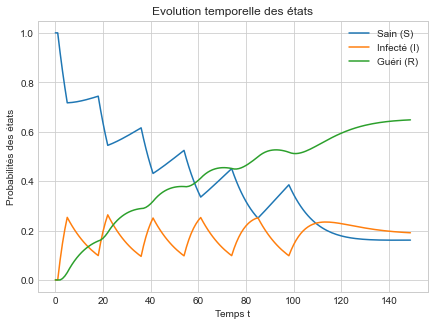

In [65]:
phi0 = [1., 0., 0.]
confinement_theorical_analysis(Anc, Ac, phi0, 150)

#### Simulations par génération de séquences

A présent, nous devons effetuer les analyses précédentes à partir d'une génération de séquences.

Nous avons généré des séquences d'états précédemment. Dans le cas précédent, les séquences des individus étaient indépendantes, car on utilisait pour chaque état à générer la même matrice de transition. Le cas dans lequel nous nous trouvons est particulier selon qu'il faut savoir dans quel mode on se trouve pour savoir quelle matrice utiliser pour la génération. Comme le mode est déterminé de façon globale, sur l'ensemble de toute la population, la génération de séquences devient alors dépendante de toute la population.

Ecrivons la fonction `confinement_observed_analysis` qui prend les mêmes paramètres que la fonction précédente et effectue les mêmes analyses, sur des séquences générées cette fois-ci. Cette fonction prend en plus le paramètre `n` qui indique la taille de la population à étudier.

In [66]:
def confinement_observed_analysis(Anc, Ac, phi0, t, n, confinement=False, nc_seuil=0.25, c_seuil=0.1):
    T = np.arange(t)
    
    confinements = []
    deconfinements = []
    
    sequences = np.zeros((n, t))
    sequences[:, 0] = np.argmax(phi0)
    for i in range(1, t):
        A = Ac if confinement else Anc
        for j in range(n):
            sequences[j, i] = np.random.choice([0., 1., 2.], p=A[int(sequences[j, i-1])])
        
        # pourcentage de I
        pI = np.count_nonzero(sequences[:, i] == 1.) / n
        
        if confinement: # confinement
            if pI <= c_seuil:
                # proportion des infectés inférieur à c_seuil -> déconfinement
                confinement = False
                deconfinements.append(i)
        else:
            if pI >= nc_seuil:
                # proportion des infectés supérieur à nc_seuil -> confinement
                confinement = True
                confinements.append(i)
                
    print("Nombre de confinements:", len(confinements))
    print("Instants de confinement:", confinements)
    print("Nombre de déconfinements:", len(deconfinements))
    print("Instants de déconfinement:", deconfinements)
    print("La pandémie termine par un", ("confinement" if confinement else "déconfinement"))
            
    phits = np.zeros((t, 3))
    phits[:,0] = np.sum(sequences == 0., axis=0)
    phits[:,1] = np.sum(sequences == 1., axis=0)
    phits[:,2] = np.sum(sequences == 2., axis=0)
    phits /= n
        
    fig = plt.figure(figsize=(7, 5))
    plt.title(f"Evolution temporelle des états de la population modélisée N={n}")
    plt.plot(T, phits[:,0], label='Sain (S)')
    plt.plot(T, phits[:,1], label="Infecté (I)")
    plt.plot(T, phits[:,2], label="Guéri (R)")
    plt.xlabel("Temps t")
    plt.ylabel("Probabilités des états")
    plt.legend()
    plt.show()

Effectuons des simulations sur une population de 200 individus observés pendant 150 jours.

Nombre de confinements: 7
Instants de confinement: [4, 21, 42, 64, 80, 110, 148]
Nombre de déconfinements: 6
Instants de déconfinement: [17, 38, 58, 75, 95, 120]
La pandémie termine par un confinement


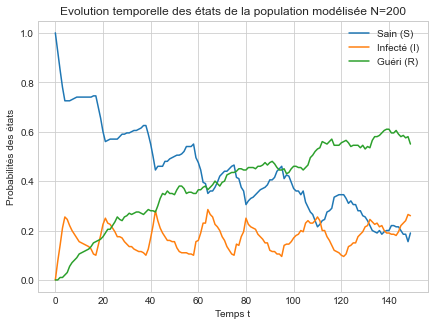

In [67]:
confinement_observed_analysis(Anc, Ac, phi0, 150, 200)

Faisons les mêmes analyses sur une population de 5000 individus.

Nombre de confinements: 5
Instants de confinement: [5, 25, 44, 65, 90]
Nombre de déconfinements: 5
Instants de déconfinement: [21, 38, 58, 79, 104]
La pandémie termine par un déconfinement


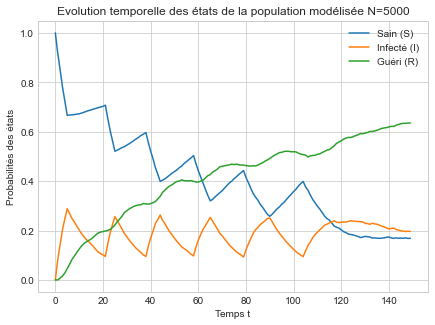

In [68]:
confinement_observed_analysis(Anc, Ac, phi0, 150, 5000)

Faisons les mêmes analyses sur une population de 5000 individus observés pendant 1000 jours.

Nombre de confinements: 5
Instants de confinement: [5, 24, 44, 66, 90]
Nombre de déconfinements: 5
Instants de déconfinement: [20, 38, 58, 79, 103]
La pandémie termine par un déconfinement


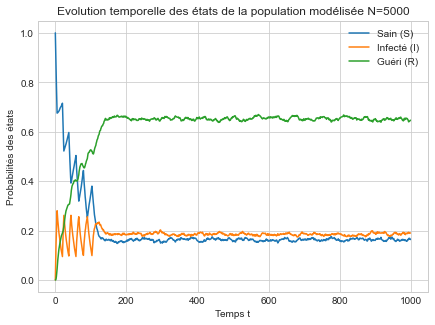

In [69]:
confinement_observed_analysis(Anc, Ac, phi0, 1000, 5000)

Sans compter le premier déconfinement initial, il faut exactement `5` confinements et `5` déconfinements.

Après le dernier déconfinement, la probabilité des états tend à leurs probabilités stationnaires. Celles-ci correspondent à celles que nous avons calculés précédemment.

Malheureusement, la maladie n'est pas complètement éradiquée. Il existe une petite portion d'individus sains; certains sont infectés ; et beaucoup guérissent.

## 5. Analyses diverses

Nous allons reprendre les modèles que nous avons étudiés dans les parties précédentes, modifier certains paramètres, refaire différentes analyses et tirer des conclusions.

### Maladie incurable

Dans ce modèle, nous allons supposer que la guérison est impossible. Les individus peuvent donc être soit sains, soit infectés.

Prenons comme matrice de transition, la matrice de transition du premier modèle et ajustons les probabilités.

In [70]:
A = np.array([[.92, .08, .0], [.0, 1., .0], [.0, .0, 1.]])
print(A)

[[0.92 0.08 0.  ]
 [0.   1.   0.  ]
 [0.   0.   1.  ]]


Effectuons une analyse sur 100 temps d'observations, avec une distribution de probabilité initaile de `[1 0 0]`.

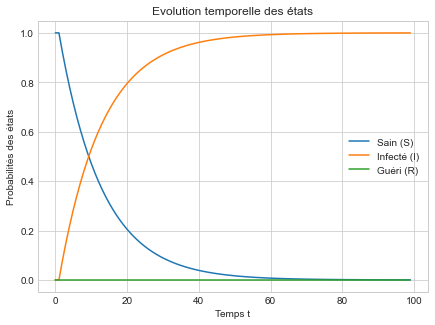

In [71]:
phi0 = [1., 0., 0.]
theorical_analysis(A, phi0, 100)

Comme aucun individu ne peut guérir de la maladie, au final, tous les individus sont infectés.

Faisons les mêmes analyses avec une distribution de probabilité initiale de `[0.8 0.15 0.05]`.

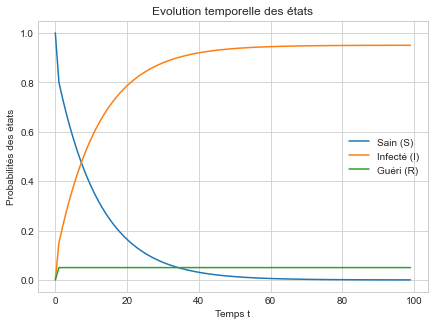

In [72]:
phi0 = [.80, .15, 0.05]
theorical_analysis(A, phi0, 100)

Générons une population de 200 individus et faisons les mêmes analyses afin d'en tirer une conclusion.

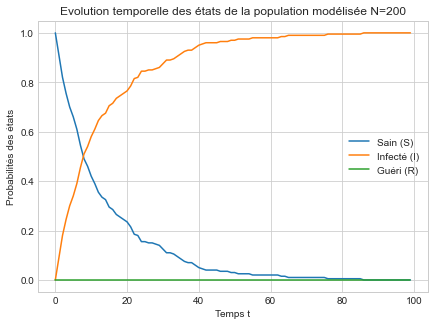

In [73]:
observed_analysis(A, phi0, 100, 200)

L'analyse théorique, du fait qu'elle cacule les distributions de probabilités par des multiplications succesives, n'annule pas la proportion d'individus guéris, car celle-ci n'est pas nulle au départ.

L'analyse sur génération de séquences ne permet aucune transition sur l'état `R` ; et on retombe sur les résulats de l'analyse théorique précédente.

En définitive, si la maladie est incurrable et qu'il n'existe donc pas de moyen pour des individus infectés de redvenir sain ; tous les individus finissent par se contaminer.

Plus bas, nous allons refaire ces mêmes tests dans un contexte de confinement et déconfinement.

### Matrice identité

Soit une matrice de transition dont la diagonale égale 1. En effet, il n'existe donc pas de transition entre les états.

In [74]:
A = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
print(A)

[[1 0 0]
 [0 1 0]
 [0 0 1]]


Effectuons une première analyse théorique sur une distribution initiale de `[1 0 0]`

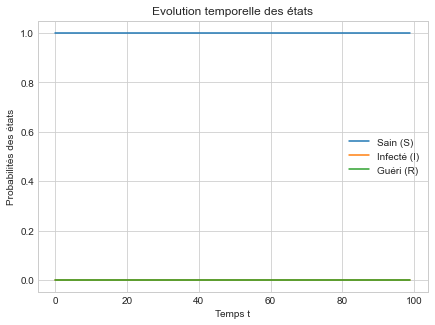

In [75]:
phi0 = [1, 0, 0]
theorical_analysis(A, phi0, 100)

Evidemment, il n'y a pas de transitions. Les probabilités d'être infectés ou guréis restent nulles.

Essayons avec une distribution initiale dans laquelle les autres états n'ont pas une probabilité nulle.

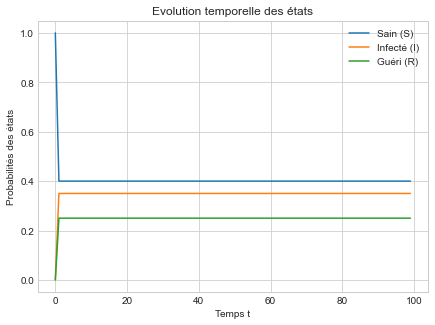

In [76]:
phi0 = [0.4, 0.35, 0.25]
theorical_analysis(A, phi0, 100)

Si la matrice de transition est la matrice identité, la distribution de probabilité stationnaire est la distribution de probabilités initiale.

### Transition unique

Nous allons étudier un nouveau modèle dans lequel pour chaque état on transite directement vers l'état suivant. Les probabilités de transitions sont de 1.

Ecrivons la matrice de transition A associée.

In [77]:
A = np.array([[0, 1, 0], [0, 0, 1], [1, 0, 0]])
print(A)

[[0 1 0]
 [0 0 1]
 [1 0 0]]


Etudions l'évolution temporelle des états en fonction des différentes distributions de probabilités initiales.

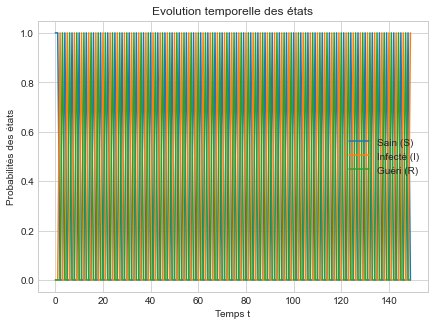

In [78]:
phi0 = [1, 0, 0]
theorical_analysis(A, phi0, 150)

Pour une meilleure visibilité nous allons représenter chaque état sur un graphique différent.

Nous allons pour cela écrire une seconde version de la fonction `theorical_analysis`.

In [79]:
def theorical_analysis2(A, phi0, t):
    T = np.arange(t)

    phits = np.zeros((t, 3))
    phits[0][np.argmax(phi0)] = 1.
    phits[1] = phi0
    for i in range(2, t):
        phits[i] = np.dot(phits[i-1], A)
        
    fig, axis = plt.subplots(figsize=(14, 10), nrows=2, ncols=2)
    
    # axis 0
    axis[0,0].set_title("Evolution temporelle des états")
    axis[0,0].plot(T, phits[:,0], label='Sain (S)')
    axis[0,0].plot(T, phits[:,1], label="Infecté (I)")
    axis[0,0].plot(T, phits[:,2], label="Guéri (R)")
    axis[0,0].set_xlabel("Temps t")
    axis[0,0].set_ylabel("Probabilités des états")
    axis[0,0].set_ylim([0,1])
    
    # axis 1
    axis[0,1].set_title("Evolution temporelle de l'état S")
    axis[0,1].plot(T, phits[:,0], label='Sain (S)')
    axis[0,1].set_xlabel("Temps t")
    axis[0,1].set_ylabel("Probabilités de l'état S")
    axis[0,1].set_ylim([0,1])
    
    # axis 2
    axis[1,0].set_title("Evolution temporelle de l'état I")
    axis[1,0].plot(T, phits[:,1], label='Infecté (I)', color="orange")
    axis[1,0].set_xlabel("Temps t")
    axis[1,0].set_ylabel("Probabilités de l'état I")
    axis[1,0].set_ylim([0,1])
    
    # axis 3
    axis[1,1].set_title("Evolution temporelle de l'état R")
    axis[1,1].plot(T, phits[:,2], label='Guéri (R)', color="green")
    axis[1,1].set_xlabel("Temps t")
    axis[1,1].set_ylabel("Probabilités de l'état R")
    axis[1,1].set_ylim([0,1])
    
    plt.legend()
    plt.show()

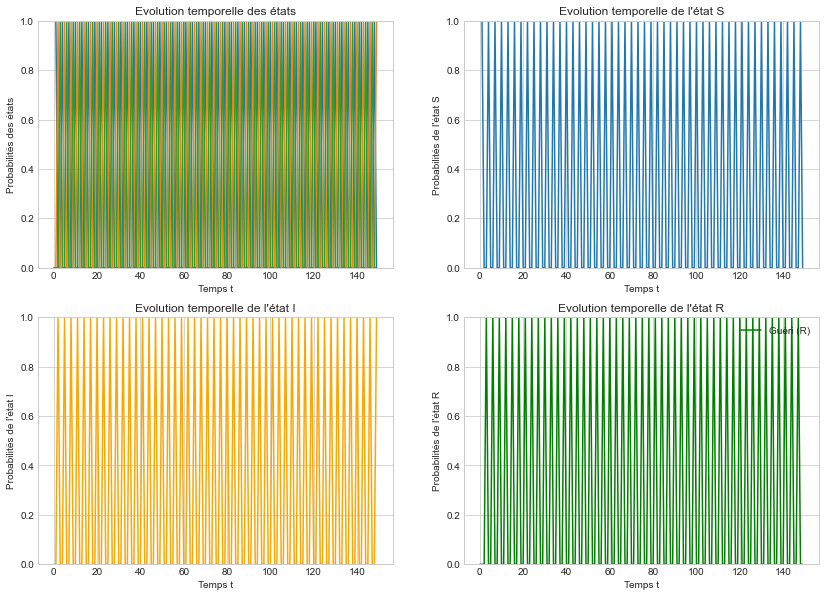

In [80]:
theorical_analysis2(A, phi0, 150)

Il y a des transitions absolument tout le temps.
Et à chaque instant, toute la population se trouve dans un même état.

Faisons les mêmes analyses sur une autre distribution de probabilités initiale.

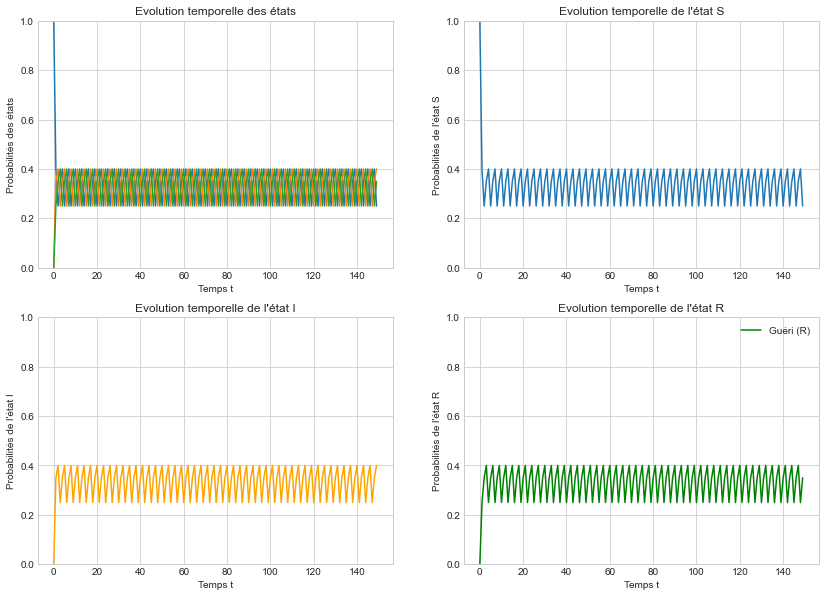

In [81]:
phi0 = [0.4, 0.35, 0.25]
theorical_analysis2(A, phi0, 150)

Le principe de transition à chaque instant est respecté. Nous constatons que les probabilités de tous les états sont soit égales à la probabilité la plus grande, soit la plus petite de la distribution de probabilité initiale.

### Graphe des états acyclique

Etudions un modèle dont le graphe des états associés ne possède de cycle. La probabilité de rester sur un état donné est nulle.

Pour ce modèle, nous allons admettre les transitions autrefois omises, telles que de `S` vers `R` et autres. Dans l'optique d'observer l'évolution des distributions des probabilités. On sort ici un peu du cadre de la logique des différents états.

Proposons une matrice de transition.

In [82]:
A = np.array([[.0, .9, .1], [.1, .0, .9], [.9, .1, 0]])
print(A)

[[0.  0.9 0.1]
 [0.1 0.  0.9]
 [0.9 0.1 0. ]]


Effectuons une analyse du modèle.

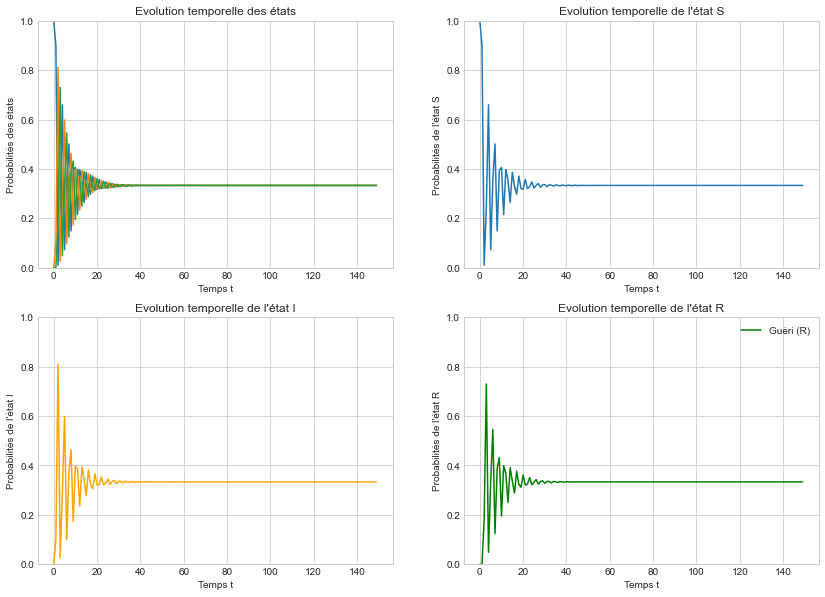

In [83]:
phi0 = [0.9, 0.1, 0]
theorical_analysis2(A, phi0, 150)

Dans la distribution de probabilités stationnaire, les probabilités des trois états semblent s'égaler.
Retrouvons cette distribution de probabilités stationnaire.

Ecrivons la fonction `stationary_distribution` qui prend en paramètre une matrice de transition `A` et retrouve la distribution de probabilités stationnaire si elle existe. Elle retourne la puissance n de la matrice `A` correspondant à cette distribution.

Il faudra préalablement s'assurer que le modèle analysé possède une telle distribution avant d'utiliser la fonction.

In [84]:
def stationary_distribution(A):
    An_1 = np.zeros_like(A)
    An = A.copy()
    #while not np.all(np.abs(An - An_1) < 1e-3):
    while not np.all(An == An_1):
        An_1 = An.copy()
        An = np.dot(An, A)
    return An

Retrouvons la distribution de probabilités stationnaire du modèle. Mettons-la dans le vecteur `phis`.

In [85]:
phis = stationary_distribution(A)[0]
print(phis)

[0.33333333 0.33333333 0.33333333]


En effet, les probabilités des états s'égalent. Elles valent toutes $\frac{1}{3}$. Pourquoi ? Cela est bien intriguant. Serait-ce dû au fait que nous repartissons `0.9` et `0.1` entre les deux autres états, pour un état donné ?

Faisons la même analyse avec une autre matrice de transition (à graphe associé acyclique) et une autre distribution de probabilité.

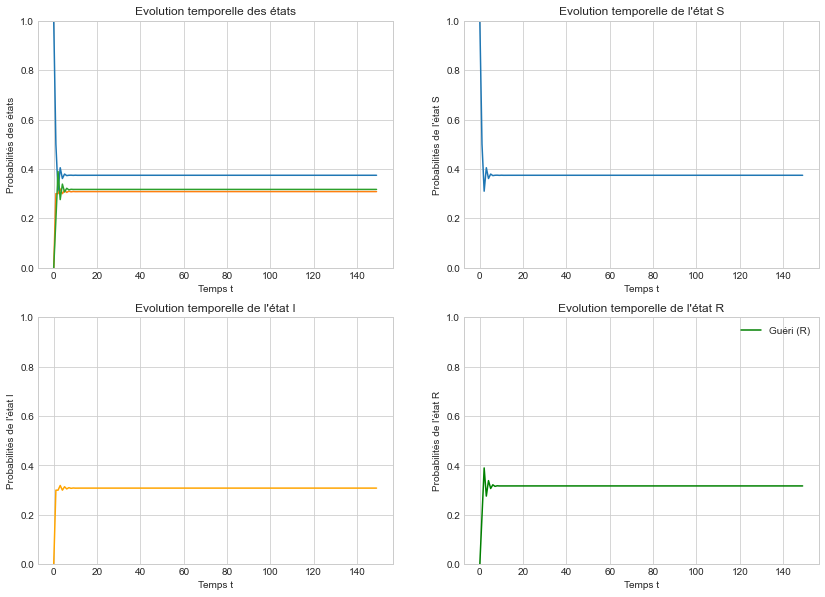

In [86]:
phi0 = [.5, .3, .2]
A = np.array([[.0, .4, .6], [.7, .0, .3], [.5, .5, .0]])
theorical_analysis2(A, phi0, 150)

Calculons la distribution de probabilités à un instant très grand.

In [87]:
phit2 = np.dot(phi0, np.linalg.matrix_power(A, 100000000000000000000))
print(phit2)

[0. 0. 0.]


Cela n'est pas apparent sur le graphique ci-haut, mais la distribution de probabilités stationnaire n'est pas ou est difficilement atteinte.

### Probabilités de transition égales

Soit un modèle où toutes les transitions sont possibles et à probabilités égales.

Ecrivons la matrice de transition.

In [88]:
A = 1/3 * np.ones((3,3))
print(A)

[[0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]]


Effectuons une première analyse.

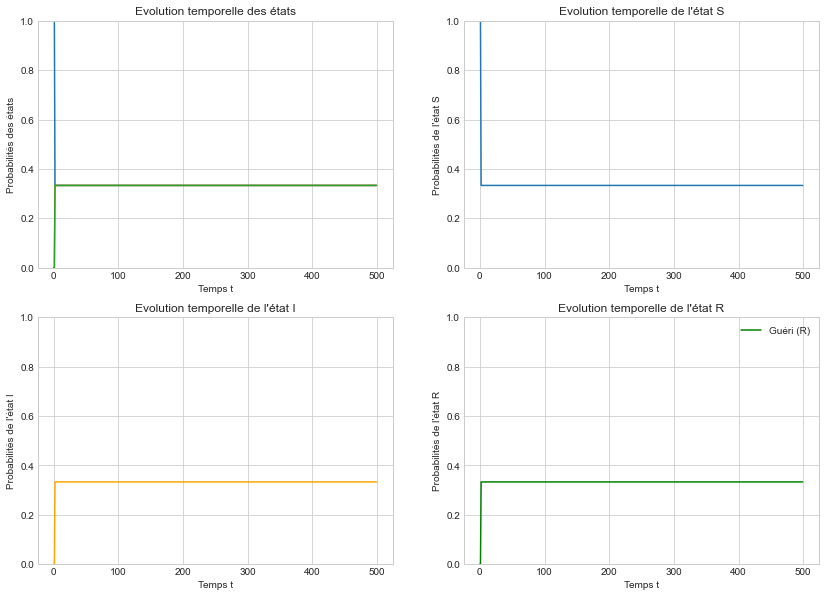

In [89]:
phi0 = [1., .0, .0]
theorical_analysis2(A, phi0, 500)

Les probabilités des états semblent finir par s'égaler.

Faisons les mêmes analyses avec une autre distribution de probabilités.

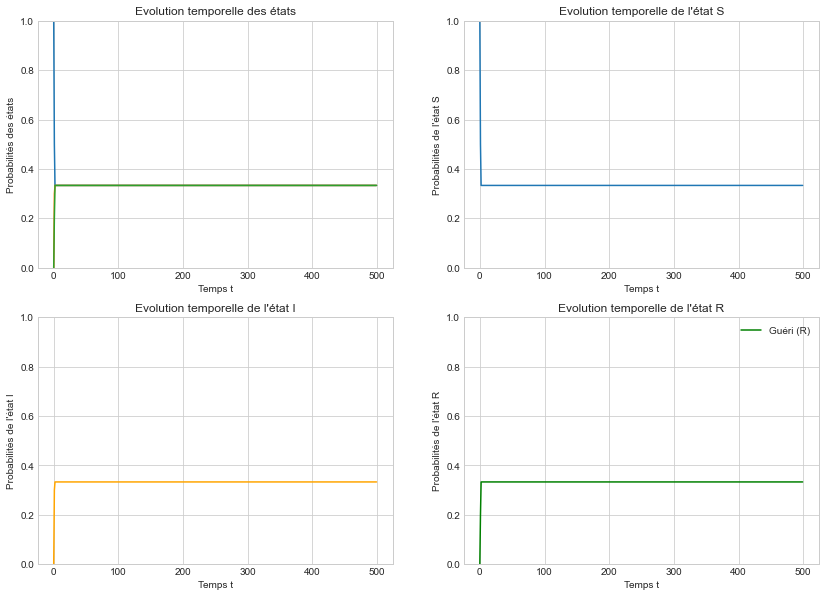

In [90]:
phi0 = [.5, .3, .2]
theorical_analysis2(A, phi0, 500)

### Matrice de transition pleine

A présent, étudions un cas un peu plus général du cas précédent. Toutes les transitions sont possibles avec des probabilités aléatoires.

Dans la suite, nous allons générer différentes matrices de transitions `sans 0` et différentes distributions de probabilités initiales et effectuer des analyses.

Distribution de probabilité stationnaire: [0.23404255 0.31914894 0.44680851]


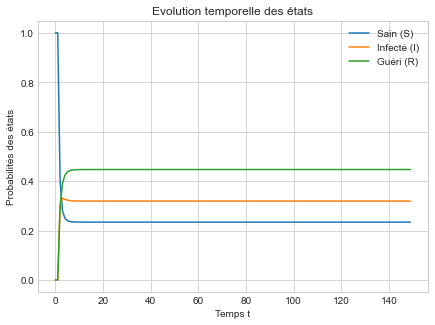

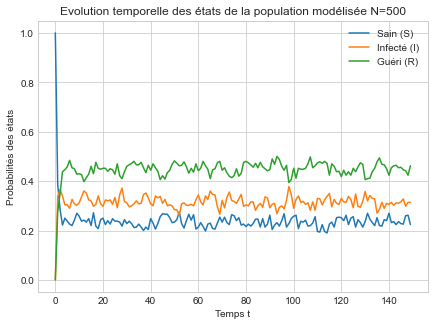

In [91]:
phi0 = [1., 0., 0.]
A = np.array([[.4, .3, .3], [.3, .5, .2], [.1, .2, .7]])
print("Distribution de probabilité stationnaire:",stationary_distribution(A)[0])
theorical_analysis(A, phi0, 150)
observed_analysis(A, phi0, 150, 500)

### Confinements / Déconfinements

Pour cette dernière étude, nous allons reprendre le principe confinement et déconfinement, effectuer des analyses avec des paramètres différents et tirer des conclusions.

Reprenons les matrices de transitions `Anc` et `Ac`, de non confinement et de confinement respectivement.

In [92]:
print(Anc, "matrice de non-confinement")
print(Ac, "matrice de confinement")

[[0.92 0.08 0.  ]
 [0.   0.93 0.07]
 [0.02 0.   0.98]] matrice de non-confinement
[[1.   0.   0.  ]
 [0.   0.93 0.07]
 [0.02 0.   0.98]] matrice de confinement


#### Mesures de restrictions strictes

Analysons la situation suivante :
- `Distribution initiale` : tous les individus sont sains
- `Durée d'observation` : 150 jours
- `Mode initial` : non-confinement
- `Seuil d'infection pour confinement` : 10%
- `Seuil d'infection pour déconfinement` : 1%

Que se passe-t-il ?

Nombre de confinements: 4
Instants de confinement: [3, 43, 82, 121]
Nombre de déconfinements: 3
Instants de déconfinement: [41, 80, 119]
La pandémie termine par un confinement


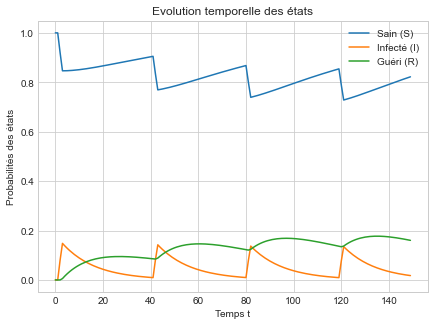

In [93]:
phi0 = [1, 0, 0]
confinement_theorical_analysis(Anc, Ac, phi0, 150, confinement=False, nc_seuil=0.10, c_seuil=0.01)

Observons les mêmes caractéristiques pendant un peu plus longtemps.

Nombre de confinements: 27
Instants de confinement: [3, 43, 82, 121, 159, 197, 235, 273, 311, 349, 387, 425, 463, 501, 539, 577, 615, 653, 691, 729, 767, 805, 843, 881, 919, 957, 995]
Nombre de déconfinements: 26
Instants de déconfinement: [41, 80, 119, 157, 195, 233, 271, 309, 347, 385, 423, 461, 499, 537, 575, 613, 651, 689, 727, 765, 803, 841, 879, 917, 955, 993]
La pandémie termine par un confinement


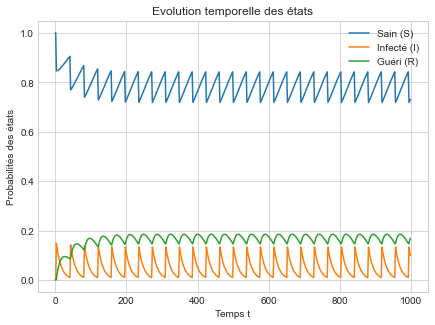

In [94]:
confinement_theorical_analysis(Anc, Ac, phi0, 1000, confinement=False, nc_seuil=0.10, c_seuil=0.01)

Observons ce qu'il se passe, si au départ `tous les individus sont infectés`. Nous nous attendons à un confinement dès les premiers instants.

Nombre de confinements: 26
Instants de confinement: [2, 67, 101, 138, 176, 214, 252, 290, 328, 366, 404, 442, 480, 518, 556, 594, 632, 670, 708, 746, 784, 822, 860, 898, 936, 974]
Nombre de déconfinements: 25
Instants de déconfinement: [65, 99, 136, 174, 212, 250, 288, 326, 364, 402, 440, 478, 516, 554, 592, 630, 668, 706, 744, 782, 820, 858, 896, 934, 972]
La pandémie termine par un confinement


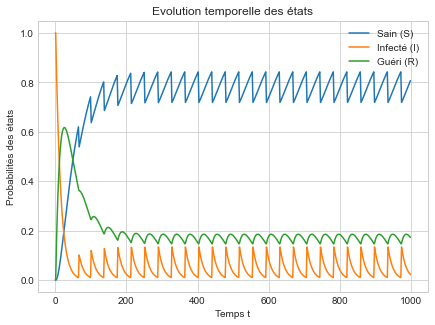

In [95]:
phi0 = [0, 1, 0]
confinement_theorical_analysis(Anc, Ac, phi0, 1000, confinement=False, nc_seuil=0.10, c_seuil=0.01)

En effet, il y a un confinement dès l'instant 2.

Observons ce qu'il se passe quand au départ, `tous les individus guérissent de la maladie`.

Nombre de confinements: 26
Instants de confinement: [20, 56, 93, 129, 166, 204, 242, 280, 318, 356, 394, 432, 470, 508, 546, 584, 622, 660, 698, 736, 774, 812, 850, 888, 926, 964]
Nombre de déconfinements: 25
Instants de déconfinement: [53, 91, 127, 164, 202, 240, 278, 316, 354, 392, 430, 468, 506, 544, 582, 620, 658, 696, 734, 772, 810, 848, 886, 924, 962]
La pandémie termine par un confinement


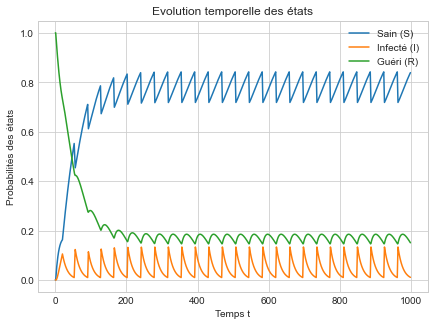

In [96]:
phi0 = [0, 0, 1]
confinement_theorical_analysis(Anc, Ac, phi0, 1000, confinement=False, nc_seuil=0.10, c_seuil=0.01)

Observons la même situation avec `une distribution de probabilités initiale complètement aléatoire`.

Nombre de confinements: 26
Instants de confinement: [2, 54, 90, 127, 165, 203, 241, 279, 317, 355, 393, 431, 469, 507, 545, 583, 621, 659, 697, 735, 773, 811, 849, 887, 925, 963]
Nombre de déconfinements: 26
Instants de déconfinement: [52, 88, 125, 163, 201, 239, 277, 315, 353, 391, 429, 467, 505, 543, 581, 619, 657, 695, 733, 771, 809, 847, 885, 923, 961, 999]
La pandémie termine par un déconfinement


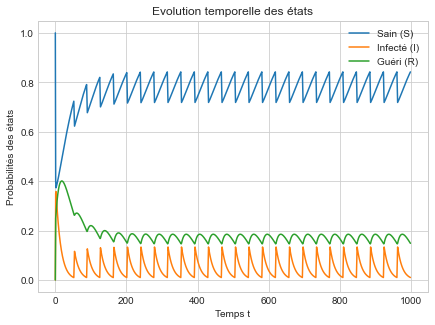

In [97]:
phi0 = [.40, .35, .25]
confinement_theorical_analysis(Anc, Ac, phi0, 1000, confinement=False, nc_seuil=0.10, c_seuil=0.01)

La période d'observation commence par un `confinement`.

Nombre de confinements: 26
Instants de confinement: [52, 88, 125, 163, 201, 239, 277, 315, 353, 391, 429, 467, 505, 543, 581, 619, 657, 695, 733, 771, 809, 847, 885, 923, 961, 999]
Nombre de déconfinements: 26
Instants de déconfinement: [50, 86, 123, 161, 199, 237, 275, 313, 351, 389, 427, 465, 503, 541, 579, 617, 655, 693, 731, 769, 807, 845, 883, 921, 959, 997]
La pandémie termine par un confinement


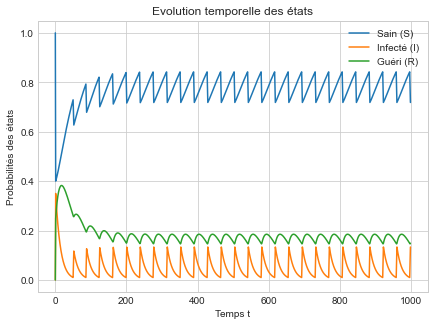

In [98]:
phi0 = [.40, .35, .25]
confinement_theorical_analysis(Anc, Ac, phi0, 1000, confinement=True, nc_seuil=0.10, c_seuil=0.01)

Un fait intéressant : des mesures de restrictions plus strictes permettent d'éviter le maximum d'infection ; cela au prix de plusieurs confinements et déconfinements successifs.

Dans notre mise en situation : 
La population se rebelle ! Elle ne veut plus subir autant de confinements ! Les personnes saines ont des membres de leur famille qui sont infectées ; elles aimeraient, au prix de finir infectés elles aussi, revoir leurs familles.
Analysons une situation moins stricte.

#### Mesures de restriction pas du tout strictes.

#### Mesures de restrictions strictes

Analysons la situation suivante :
- `Distribution initiale` : tous les individus sont sains
- `Durée d'observation` : 1000 jours
- `Mode initial` : non-confinement
- `Seuil d'infection pour confinement` : 40% (très proche du seuil maximal d'infection)
- `Seuil d'infection pour déconfinement` : 35%

Que se passe-t-il ?

Nombre de confinements: 1
Instants de confinement: [12]
Nombre de déconfinements: 1
Instants de déconfinement: [15]
La pandémie termine par un déconfinement


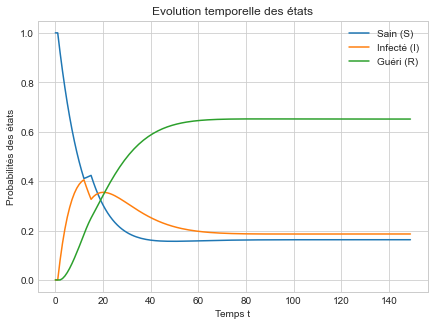

In [99]:
phi0 = [1, 0, 0]
confinement_theorical_analysis(Anc, Ac, phi0, 150, confinement=False, nc_seuil=0.40, c_seuil=0.35)

On observe pas beaucoup de confinements, pas beaucoup de déconfinements. La pandémie se termine par un déconfinement. 

Malheureusement, le nombre d'individus infectés surpasse le nombre d'individus sains. Pour certaines pandémies, cela peut être une situation que l'on voudrait à tout prix éviter.

Observons d'autres situations un peu plus restrictives.
- `Seuil d'infection pour confinement` : 30%
- `Seuil d'infection pour déconfinement` : 20%

Nombre de confinements: 3
Instants de confinement: [7, 18, 31]
Nombre de déconfinements: 3
Instants de déconfinement: [14, 24, 37]
La pandémie termine par un déconfinement


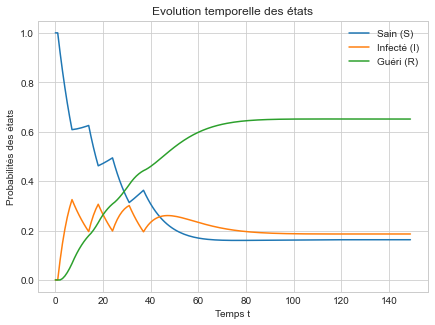

In [100]:
phi0 = [1, 0, 0]
confinement_theorical_analysis(Anc, Ac, phi0, 150, confinement=False, nc_seuil=0.30, c_seuil=0.20)